In [118]:
import pickle
from utils import data_handler
import xgboost as xgb
import shap
import numpy as np
import matplotlib.pylab as pl
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_roc_curve, accuracy_score, f1_score, plot_confusion_matrix, cohen_kappa_score, plot_precision_recall_curve, roc_curve, auc, recall_score, precision_score
import pandas as pd
import matplotlib.pyplot as plt

# print the JS visualization code to the notebook
shap.initjs()


## Load data, XGBoost model and Random Forest model

In [2]:
with open('./model.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [34]:
with open('./rf_model.pkl', 'rb') as f:
    rf_pipe = pickle.load(f)

In [3]:
xgboost_classifier = pipe.steps[2][1]
remove_cols_class = pipe.steps[0][1]
custom_imputer = pipe.steps[1][1]

In [35]:
rf_classifier = pipe.steps[2][1]

In [4]:
with open('data/X_y.pkl', 'rb') as f:
        X, y = pickle.load(f)

In [5]:
X_t = custom_imputer.transform(remove_cols_class.transform(X))

In [6]:
with open('data/X_test_y_ture.pkl', 'rb') as f:
    X_test, ytrue = pickle.load(f)

## Shapely Values

**XGBoost**

In [7]:
explainer = shap.TreeExplainer(xgboost_classifier)
shap_values = explainer.shap_values(X_t)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


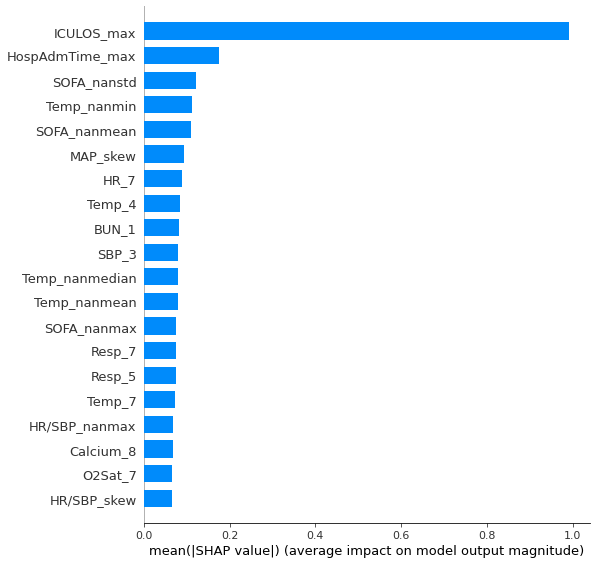

In [8]:
shap.summary_plot(shap_values, X_t, plot_type="bar")

**Random Forest**

In [36]:
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_t)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


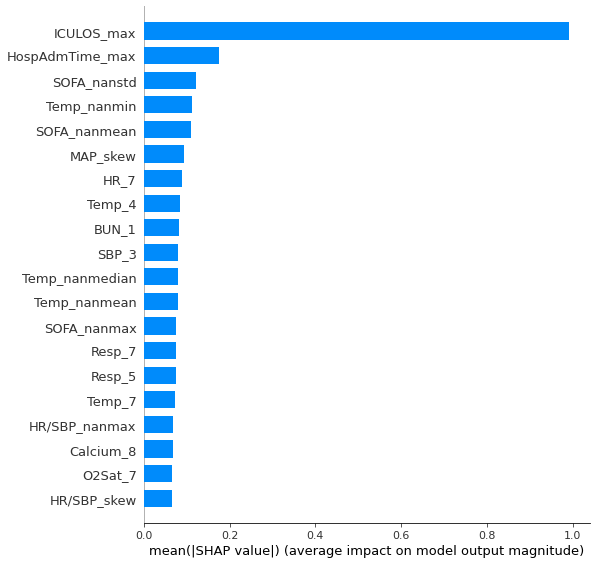

In [132]:
shap.summary_plot(shap_values, X_t, plot_type="bar")

## Different Metrics

### ROC Curve

**XGBoost**

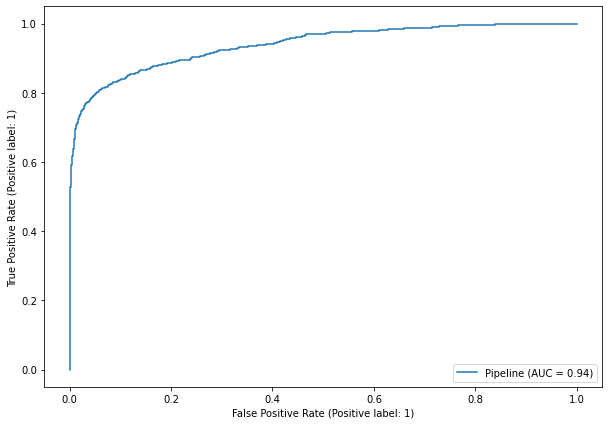

In [9]:
fig, ax = pl.subplots(1,1,figsize=(10,7))
plot_roc_curve(pipe, X_test, ytrue, ax=ax)
pl.show()

**Random Forest**

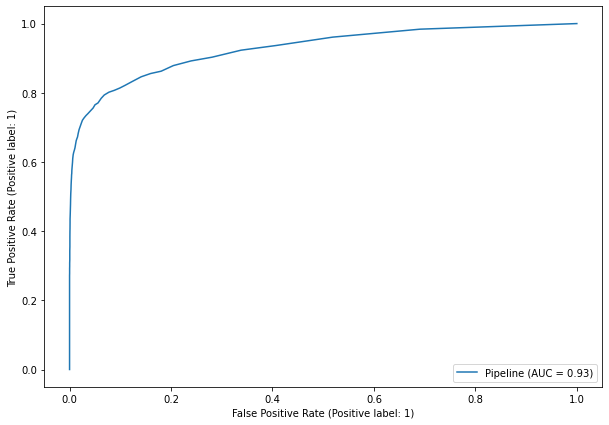

In [38]:
fig, ax = pl.subplots(1,1,figsize=(10,7))
plot_roc_curve(rf_pipe, X_test, ytrue, ax=ax)
pl.show()

### Accuracy

**XGBoost**

In [10]:
ypreds = pipe.predict(X_test)
accuracy_score(ytrue, ypreds)

0.9663

**Random Forest**

In [39]:
rf_ypreds = rf_pipe.predict(X_test)
accuracy_score(ytrue, rf_ypreds)

0.9589

### F1

**XGBoost**

In [11]:
f1_score(ytrue, ypreds, average='binary')

0.7335968379446641

In [12]:
f1_score(ytrue, ypreds, average='macro')

0.8578045572162605

**Random Forest**

In [40]:
f1_score(ytrue, rf_ypreds, average='binary')

0.6267029972752044

In [41]:
f1_score(ytrue, rf_ypreds, average='macro')

0.802477907442301

### Confusion Matrix

In [129]:
plt.rcParams.update({'font.size': 16})

**XGBoost**

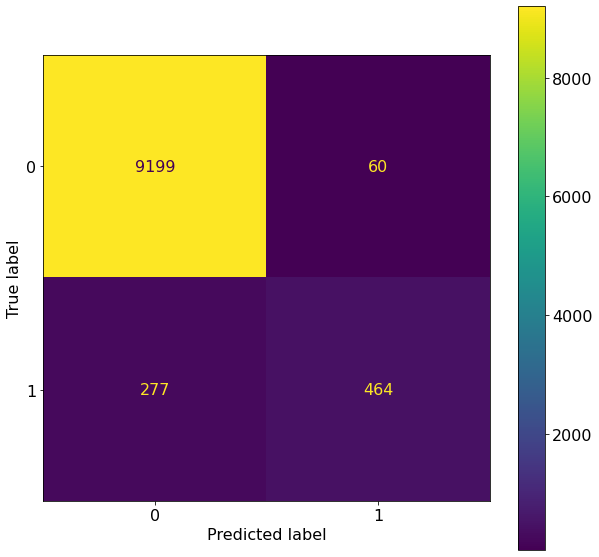

In [130]:
fig, ax = pl.subplots(1,1,figsize=(10,10))
plot_confusion_matrix(pipe, X_test, ytrue, ax=ax)
pl.show()

**Random Forest**

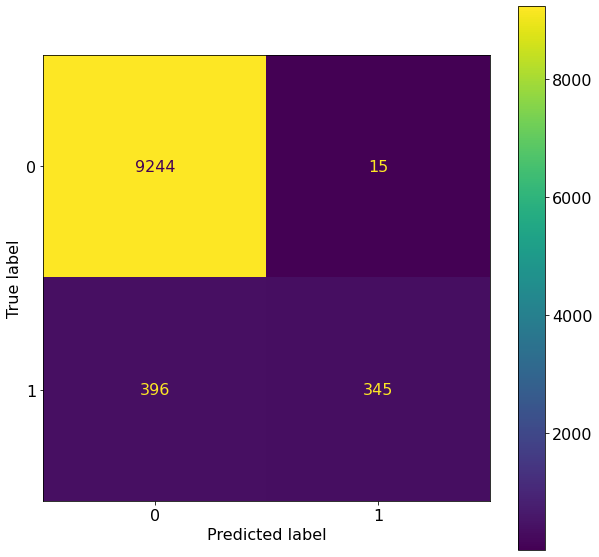

In [131]:
fig, ax = pl.subplots(1,1,figsize=(10,10))
plot_confusion_matrix(rf_pipe, X_test, ytrue, ax=ax)
pl.show()

### Precision-Recall Curve

**XGBoost**

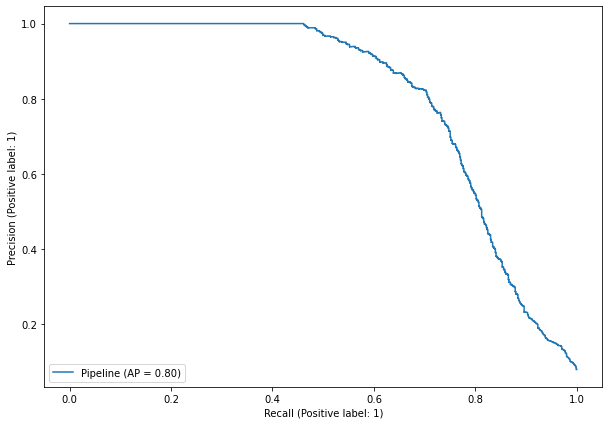

In [16]:
fig, ax = pl.subplots(1,1,figsize=(10,7))
plot_precision_recall_curve(pipe, X_test, ytrue, ax=ax)
pl.show()

In [121]:
precision_score(ytrue, ypreds)

0.8854961832061069

In [122]:
recall_score(ytrue, ypreds)

0.6261808367071525

**Random Forest**

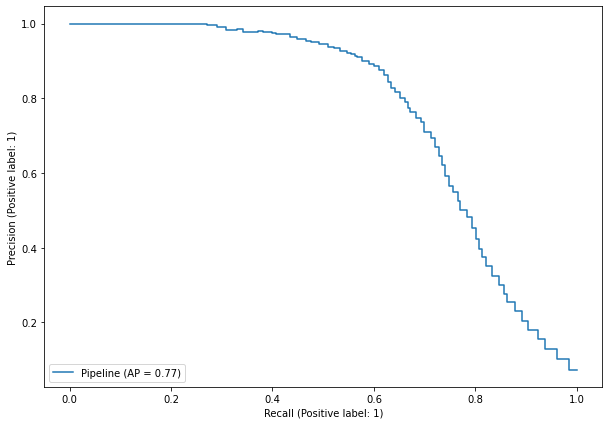

In [45]:
fig, ax = pl.subplots(1,1,figsize=(10,7))
plot_precision_recall_curve(rf_pipe, X_test, ytrue, ax=ax)
pl.show()

In [124]:
precision_score(ytrue, rf_ypreds)

0.9583333333333334

In [125]:
recall_score(ytrue, rf_ypreds)

0.46558704453441296

## Result Comparison Between Groups

In [154]:
plt.rcParams.update({'font.size': 14})

In [155]:
df = X_test.copy()

In [156]:
bins = [10, 30, 50, 70, 90]
labels = [str(bins[i]) + '-' + str(bins[i+1]-1) for i in range(len(bins)-1)]
df['Age_range'] = pd.cut(df.Age_max, bins, labels=labels, include_lowest=True)

categorical_features = ['Gender_nanmax', 'Unit1_nanmax', 'Unit2_nanmax', 'Age_range']
df = df[categorical_features]

categorical_features = ['Gender', 'Unit1', 'Unit2', 'Age_range']
df.columns = categorical_features
df['y_true'] = ytrue
df['Gender'] = df['Gender'].apply(lambda x: 'Female' if x== 0 else 'Male')

In [166]:
def barplot_from_dict(dict_, ax, title, xlabel):
    
    ax.bar(range(len(dict_)), list(dict_.values()), align='center')
    ax.set_xticks(ticks=range(len(dict_)));
    ax.set_xticklabels(list(dict_.keys()))
    ax.set_ylabel(title)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    
def plot_f1_results_per_group(group_feature, title):
    f1_dict = {}
    count_dict = {}
    for category, group in df.groupby(group_feature):
        f1_dict[category] = f1_score(group['y_true'], group['y_preds'])
        count_dict[category] = len(group)
    fig, axs = plt.subplots(2, 1, figsize = (7, 9))
    fig.suptitle(title)
    barplot_from_dict(count_dict, axs[0], 'Count', group_feature)
    barplot_from_dict(f1_dict, axs[1], 'Binary F1 for Group', group_feature)
    plt.tight_layout()
    plt.show()


**Random Forest**

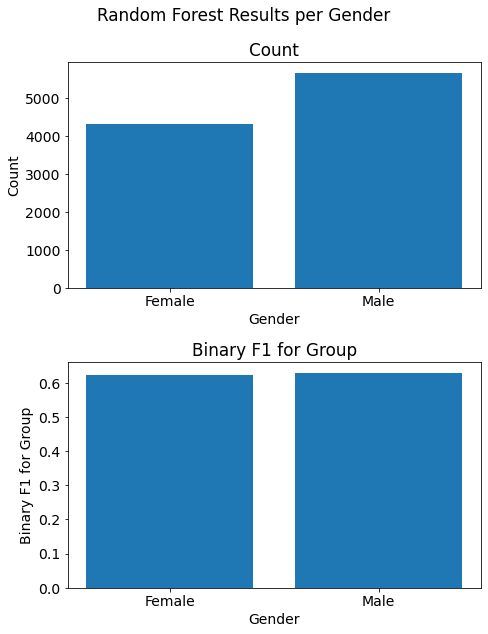

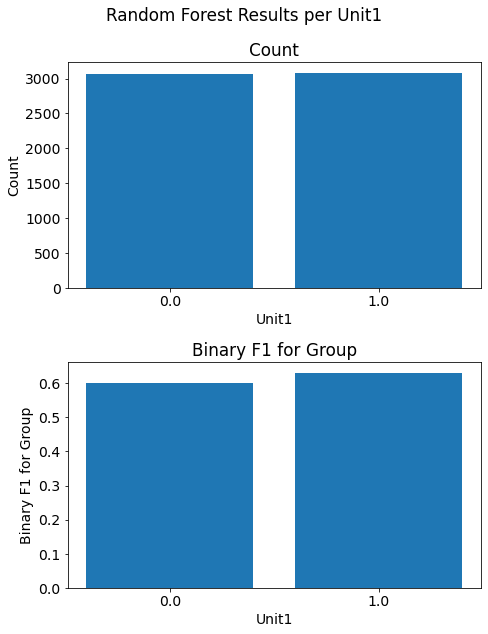

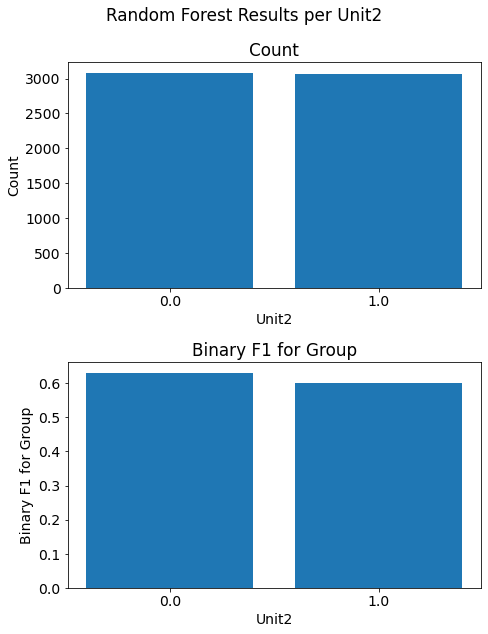

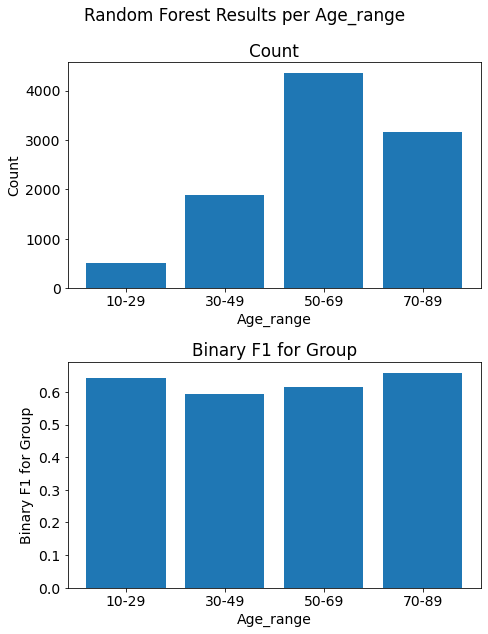

In [171]:
ypreds = rf_pipe.predict(X_test)
df['y_preds'] = ypreds
for categorical_feature in categorical_features:
    plot_f1_results_per_group(categorical_feature, 'Random Forest Results per ' + categorical_feature)

**XGBoost**

In [167]:
ypreds = pipe.predict(X_test)
df['y_preds'] = ypreds


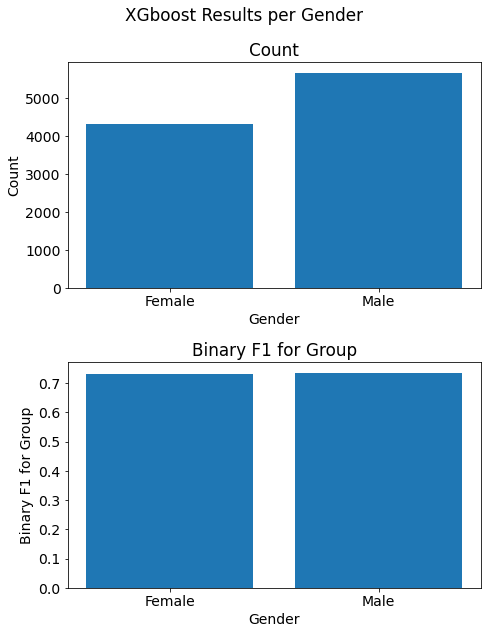

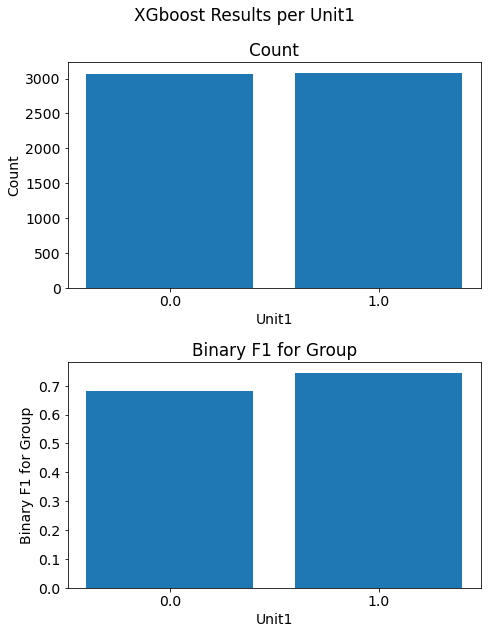

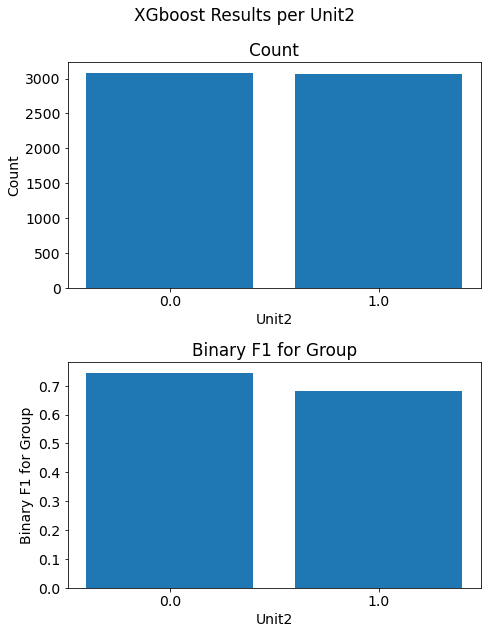

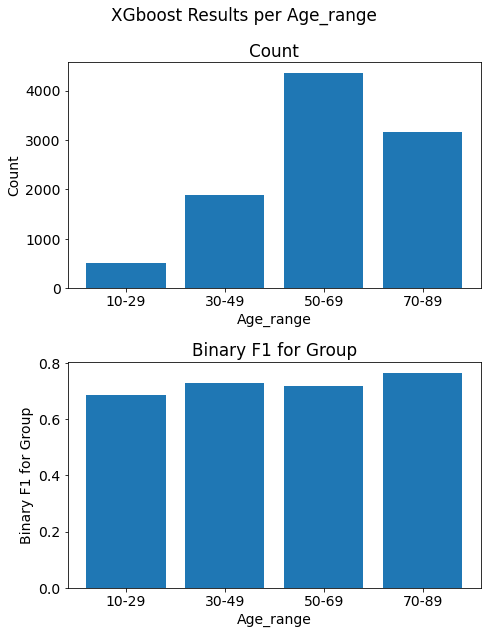

In [168]:
for categorical_feature in categorical_features:
    plot_f1_results_per_group(categorical_feature, 'XGboost Results per ' + categorical_feature)